In [ ]:
import yaml
import pymongo
with open("/global/homes/o/oevans/.mongo.yaml") as fh:
    config = yaml.load(fh)
# Open database
mongo = pymongo.MongoClient(**config)[config['authSource']]
coll = mongo['kelp-gridstudy']

grid_sizes = set([(c['ns'], c['na']) for c in coll.find({'gmres_flag': True})])
grid_sizes
# Look at everything in the last day
#yesterday = datetime.datetime.now() - datetime.timedelta(days=1)

# Get results
#for record in coll.find({'date': {'$gte': yesterday}, 'gmres_flag': True}):
#    print(record['a_water'])
#    print(record['b'])
#    print(record['gmres_flag'])
#    print(record['num_scatters'])
#    #print(record['irradiance'].mean())


In [ ]:
ns = 12
na = 6
max_scatter = 3
runs = [c for c in coll.find({'gmres_flag': True, 'ns': ns, 'ns': ns})]
compute_results_list = []
true_save_list = []
save_list = []
for i, run in enumerate(runs):
    with open(run['results_path'], 'rb') as fh:
        result = dill.load(fh)
    const = list(dill.loads(run['const']))
    print(result['duration'])
    print([{k: v} for k, v in run.items() if type(v) in [str, float, int]])
    
    # Run asymptotic cases
    inner_res_list = []
    inner_save_list = []
    print("A")
    
    p_kelp = result['p_kelp']
    true_irrad = result['irradiance']
    true_perceived_irrad = np.sum(p_kelp*true_irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
    
    true_save = {
        'perceived_irrad': true_perceived_irrad
    }
    
    true_save_list.append(true_save)
    
    for n in range(max_scatter+1):
        print("n={}".format(n))
        # Set GMRES flag False
        const[19] = False
        # Set num_scatter
        const[13] = n
        #print("const={}".format(const))
        compute_results = kelp_calculate(
            run['a_water'], 
            run['b'], 
            run['ns'], 
            run['na'], 
            run['kelp_profile'],
            const, num_threads=1
        )
        
        print("ns={}".format(run['ns']))
        irrad = compute_results['irradiance']
        # Perceived irradiance for each depth layer
        perceived_irrad = np.sum(p_kelp*irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
        err = np.abs(true_perceived_irrad - perceived_irrad)
        rad_err = np.mean(compute_results['radiance'] - result['radiance'])
        
        save_vals = {
            'abs_err': err,
            'rel_err': err / np.abs(true_perceived_irrad),
            'perceived_irrad': perceived_irrad,
            'abs_rad_err': rad_err,
            'rel_rad_err': rad_err / np.abs(result['radiance'])
        }
        
        inner_res_list.append(compute_results)
        inner_save_list.append(save_vals)
    compute_results_list.append([inner_res_list])
    save_list.append(inner_save_list)

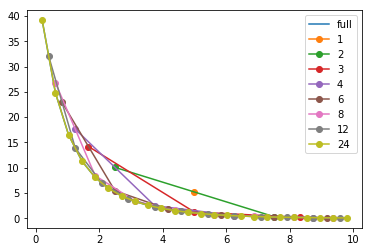

In [58]:
# Verify block_mean
nz = len(exact_irrad)
dz = (zmax-zmin)/nz
z = np.linspace(zmin+dz/2, zmax-dz/2, nz)
plt.plot(z, exact_irrad, label='full')
for nz in divisors(nz):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+dz/2, zmax-dz/2, nz)
    plt.plot(z, kelp_param.block_mean(exact_irrad, [nz]), 'o-', label=nz)
plt.legend()
plt.show()